In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

In [2]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [3]:
def concatenate_iteration_dfs(iteration_dfs):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True).sort_values(by='iteration')    

In [4]:
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "performance_iteration_0.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "performance_iteration_1.json",
        'iteration': 1
    },
]
path_to_labels = Path.cwd() / "resources" / "labels"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)

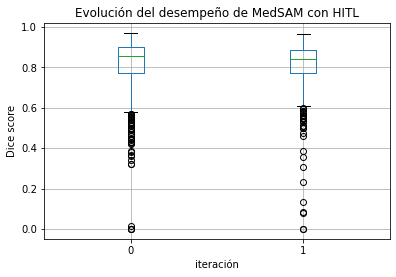

dice_score                                                         \
               count      mean       std  min       25%       50%       75%   
iteration                                                                     
0              585.0  0.810139  0.140890  0.0  0.769912  0.857831  0.900302   
1              587.0  0.809499  0.124725  0.0  0.771853  0.841530  0.885436   

                     
                max  
iteration            
0          0.970982  
1          0.963100

In [5]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.title('Evolución del desempeño de MedSAM con HITL')
plt.xlabel('iteración')
plt.ylabel('Dice score')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe())

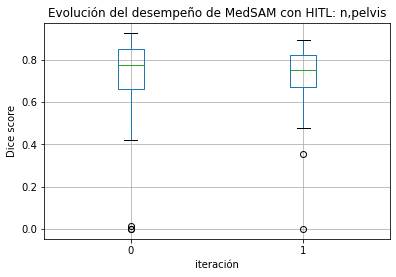

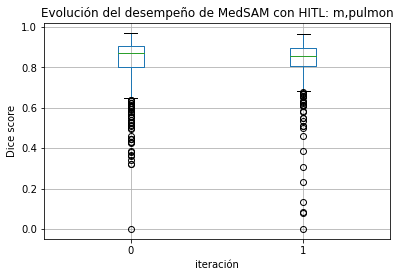

count      mean       std  min       25%  \
label_description iteration                                             
m,pulmon          0          476.0  0.828493  0.125744  0.0  0.800000   
                  1          476.0  0.828431  0.116223  0.0  0.806605   
n,pelvis          0          109.0  0.729988  0.172705  0.0  0.661355   
                  1          111.0  0.728317  0.127835  0.0  0.671170   

                                  50%       75%       max  
label_description iteration                                
m,pulmon          0          0.867825  0.906073  0.970982  
                  1          0.854351  0.893361  0.963100  
n,pelvis          0          0.775385  0.850202  0.927711  
                  1          0.750733  0.822217  0.892857

In [6]:
# Boxplot of Dice score for each iteration, dissagregated by lesion type
unique_lesions = list(performance_df['label_description'].unique())
for lesion in unique_lesions:
    performance_df[performance_df['label_description'] == lesion].boxplot(column='dice_score', by='iteration')
    plt.suptitle('')
    plt.title(f'Evolución del desempeño de MedSAM con HITL: {lesion}')
    plt.xlabel('iteración')
    plt.ylabel('Dice score')
    plt.show()
display(performance_df.groupby(['label_description', 'iteration'])['dice_score'].describe())

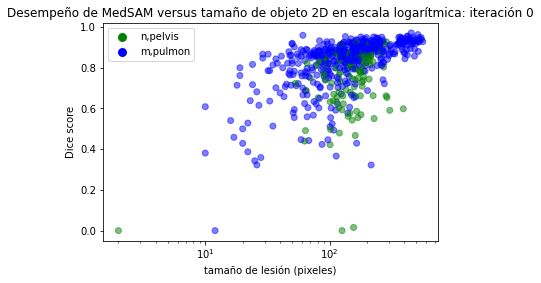

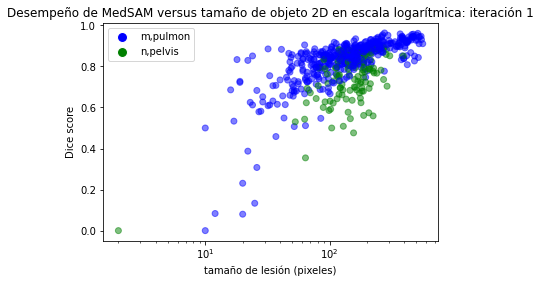

In [7]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
# Add a color for each unique label description
color_mapping = {
    "m,pulmon": 'blue',
    "n,pelvis": 'green'
}
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_title(f'Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica: iteración {iteration}')
    ax.set_xlabel('tamaño de lesión (pixeles)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in filtered_df['label_description'].unique()
    ]
    ax.legend(handles=legend_labels)
    #plt.savefig(
    #    Path.cwd() / "resources" / "scatterplot_performance_vs_object_size.png",
    #    transparent=True,
    #    bbox_inches='tight'
    #)
    plt.show()

**Warning**: Ambos dataframes deberían tener la misma cantidad de ROIs evaluados (filas), pero difieren. Hay 582 ROIs que coinciden en ambos dataframes, pero hay:
- 3 que están en la iteración 0 y no están en la iteración 1, y
- 5 que están en la iteración 1 y no están en la iteración 0.

In [8]:
with open(iteration_dfs[0]['path'], 'r') as file:
    performance_0 = json.load(file)['bboxes']
with open(iteration_dfs[1]['path'], 'r') as file:
    performance_1 = json.load(file)['bboxes']
print(f"len performance 0: {len(performance_0)}")
print(f"len performance 1: {len(performance_1)}")

len performance 0: 585
len performance 1: 587


In [9]:
duplicated = performance_df['bbox_original_fname'].duplicated(keep=False)
not_duplicated = duplicated[duplicated == False]
display(not_duplicated)
display(performance_df.iloc[not_duplicated.index])

367    False
389    False
439    False
877    False
969    False
974    False
975    False
984    False
Name: bbox_original_fname, dtype: bool

,path_to_cts,path_to_masks,path_to_output,dataset_fname_relation,mask_fname,ct_fname,study,slice_idx,slice_rows,slice_cols,...,path_to_preprocessed_slice,bbox_original_fname,bbox_original,bbox_1024,annotated_pixels,predicted_pixels,dice_score,iteration,series_uuid,label_description
367,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/annotations-sample-GP/,same_name,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,40,512,512,...,results/annotations-sample-GP/preprocessed/1.3...,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,"[193, 269, 205, 286]","[386, 538, 410, 572]",101,57,0.632911,0,1.3.12.2.1107.5.1.4.83504.30000020040114181387...,"n,pelvis"
389,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/annotations-sample-GP/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,36,512,512,...,results/annotations-sample-GP/preprocessed/1.3...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[166, 280, 183, 302]","[332, 560, 366, 604]",157,162,0.664577,0,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"n,pelvis"
439,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/annotations-sample-GP/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,36,512,512,...,results/annotations-sample-GP/preprocessed/1.3...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[308, 282, 319, 301]","[616, 564, 638, 602]",164,168,0.927711,0,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"n,pelvis"
877,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/MedSAM-ViT-B-20240322-0004/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,35,512,512,...,results/MedSAM-ViT-B-20240322-0004/preprocesse...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[167, 284, 181, 299]","[334, 568, 362, 598]",99,106,0.585366,1,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"n,pelvis"
969,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/MedSAM-ViT-B-20240322-0004/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,41,512,512,...,results/MedSAM-ViT-B-20240322-0004/preprocesse...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[304, 288, 328, 301]","[608, 576, 656, 602]",240,172,0.766990,1,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"n,pelvis"
974,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/MedSAM-ViT-B-20240322-0004/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,37,512,512,...,results/MedSAM-ViT-B-20240322-0004/preprocesse...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[307, 280, 320, 301]","[614, 560, 640, 602]",192,143,0.853731,1,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"n,pelvis"
975,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/MedSAM-ViT-B-20240322-0004/,same_name,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,37,512,512,...,results/MedSAM-ViT-B-20240322-0004/preprocesse...,1.3.12.2.1107.5.1.4.83504.30000020011313523232...,"[166, 279, 183, 302]","[332, 558, 366, 604]",207,218,0.574118,1,1.3.12.2